# Оптимизация Управления Персоналом с использованием Машинного Обучения

## Введение
HR-аналитики компании «Работа с Заботой» активно внедряют машинное обучение для более эффективного управления персоналом. В рамках этого процесса бизнес предоставляет данные, а аналитики, используя методы машинного обучения, предлагают решения по избежанию финансовых потерь и снижению оттока сотрудников.

Для этой задачи заказчик предоставил данные с признаками:

`id` — уникальный идентификатор сотрудника;

`dept`— отдел, в котором работает сотрудник;

`level` — уровень занимаемой должности;

`workload` — уровень загруженности сотрудника;

`employment_years` — длительность работы в компании (в годах);

`last_year_promo` — показывает, было ли повышение за последний год;

`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;

`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;

`salary` — ежемесячная зарплата сотрудника;

`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Задача
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Задача первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Заключение
Внедрение машинного обучения в аналитические процессы HR-аналитиков позволит быстрее и точнее реагировать на запросы бизнеса, предоставляя конкретные рекомендации по оптимизации управления персоналом.

In [1]:
def analyze_dataframe(df, id_column='id'):
    # Проверка на наличие дубликатов без учета столбца 'id'
    df_no_id = df.drop(columns=[id_column], errors='ignore')
    duplicates_no_id = df_no_id[df_no_id.duplicated(keep=False)]
    
    if not duplicates_no_id.empty:
        print("\n\033[91mОбнаружены дубликаты данных (без учета столбца '{}'):\033[0m".format(id_column))
        display(duplicates_no_id)
    else:
        print("\n\033[92mДубликатов данных (без учета столбца '{}') не найдено.\033[0m".format(id_column))
    
    # Проверка на наличие дубликатов с учетом столбца 'id'
    duplicates_with_id = df[df.duplicated(keep=False)]
    
    if not duplicates_with_id.empty:
        print("\n\033[91mОбнаружены дубликаты данных (с учетом столбца '{}'):\033[0m".format(id_column))
        display(duplicates_with_id)
    else:
        print("\n\033[92mДубликатов данных (с учетом столбца '{}') не найдено.\033[0m".format(id_column))

    # Проверка на наличие пропусков
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\n\033[91mОбнаружены пропуски данных:\033[0m")
        print(missing_values)
    else:
        print("\n\033[92mПропусков данных не найдено.\033[0m")

    # Общая информация о DataFrame
    print("\n\033[94mОбщая информация о DataFrame:\033[0m")
    df.info()

    # Описание количественных данных
    print("\n\033[94mОписание количественных данных:\033[0m")
    display(df.describe())

    # Описание категориальных данных
    categorical_columns = df.select_dtypes(include=['object']).columns
    if not categorical_columns.empty:
        print("\n\033[94mОписание категориальных данных:\033[0m")
        display(df[categorical_columns].describe())
    else:
        print("\n\033[92mКатегориальных данных в DataFrame не найдено.\033[0m")

    # Дополнительные аспекты для беглого анализа данных
    print("\n\033[94mДополнительные аспекты для беглого анализа данных:\033[0m")

    # 1. Распределение значений в категориальных признаках
    for column in categorical_columns:
        print(f"\n\033[94mРаспределение значений в {column}:\033[0m")
        display(df[column].value_counts())

    # 2. Корреляция между признаками с использованием phik
    print("\n\033[94mКорреляция между признаками (phik):\033[0m")
    phik_matrix = df.phik_matrix()

    # Визуализация корреляции (пример)
    plt.figure(figsize=(10, 8))
    sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Тепловая карта корреляции (phik)')
    plt.show()

    # Вывод уникальных пар с сильной корреляцией и их силы (задайте порог корреляции по вашему усмотрению)
    strong_corr_threshold = 0.8
    strong_corr_pairs = set()

    for i, col in enumerate(phik_matrix.columns):
        correlated_cols = phik_matrix.index[i+1:][phik_matrix[col][i+1:] > strong_corr_threshold].tolist()
        for correlated_col in correlated_cols:
            pair = (col, correlated_col)
            correlation_strength = phik_matrix.at[correlated_col, col]
            strong_corr_pairs.add((pair, correlation_strength))

    if strong_corr_pairs:
        print("\n\033[94mПары с сильной корреляцией и их сила:\033[0m")
        for pair, strength in strong_corr_pairs:
            print(f"{pair}: {strength:.2f}")
    else:
        print("\n\033[92mСильной корреляции в датасете не найдено.\033[0m")




def plot_distribution_summary(df, column):
    if isinstance(column, str):
        column = [column]

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    # Первый подграфик - гистограмма
    sns.histplot(data=df[column], kde=True, ax=axes[0])
    axes[0].grid()
    axes[0].set_title("Гистограмма")
    axes[0].set_xlabel(None)

    # Второй подграфик - настраиваемый boxplot
    sns.boxplot(data=df[column], palette='pastel', notch=True,
                linewidth=2, width=0.5, orient='horizontal', ax=axes[1])
    axes[1].set_title("Boxplot")
    axes[1].set_xlabel(None)

    # Добавление сетки на обоих подграфиках
    axes[0].grid(True)
    axes[1].grid(True)

    # Добавление медианы и среднего значения на график
    median = df[column].median()
    mean = df[column].mean()
    for i, col in enumerate(column):
        # Добавление медианы (черта и подпись)
        axes[1].axvline(median[col], color='red', linestyle='--', linewidth=2, label=f'Median ({col})')
        axes[1].text(median[col], i, f'Median: {median[col]:.2f}', va='top', ha='left', color='red')

        # Добавление среднего значения (черта и подпись)
        axes[1].axvline(mean[col], color='blue', linestyle='--', linewidth=2, label=f'Mean ({col})')
        axes[1].text(mean[col], i, f'Mean: {mean[col]:.2f}', va='bottom', ha='left', color='blue')

    # Добавление подписей
    axes[1].set_yticklabels(column)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


def enhanced_bar_plot(df, column, rot=0):
    sns.set(style="whitegrid")

    balance_class = df[column].value_counts()
    x = balance_class.index
    y = balance_class.values

    # Используем цвета и добавляем обводку
    sns.barplot(x=x, y=y, palette='viridis', edgecolor='black')

    plt.title(f'Баланс классов {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')

    # Увеличиваем размер шрифта
    for i in range(len(x)):
        plt.text(i, y[i] + 5, f'{y[i]}', fontsize=12, ha='center')

    # Сортируем значения на графике
    plt.xticks(rotation=rot, ha='right')
    plt.tight_layout()
    plt.show()


In [2]:
!pip install phik optuna -q

In [ ]:
!pip install lightgbm -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import make_scorer

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import optuna
from IPython.display import clear_output
from sklearn.metrics import roc_curve, auc, roc_auc_score

from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

## Задача 1: Предсказание Уровня Удовлетворённости Сотрудника

### Шаг 1: Загрузка данных
- Тренировочная выборка: [train_job_satisfaction_rate.csv](https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv)
- Входные признаки тестовой выборки: [test_features.csv](https://code.s3.yandex.net/datasets/test_features.csv)
- Целевой признак тестовой выборки: [test_target_job_satisfaction_rate.csv](https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv)

### Шаг 2: Предобработка данных
- Изучение данных, выявление пропусков.
- Предобработка данных в пайплайне, заполнение пропусков при необходимости.

### Шаг 3: Исследовательский Анализ Данных
- Исследование всех признаков и выводы о подготовке данных.
  
### Шаг 4: Подготовка данных
- Расширение пайплайна предобработки для подготовки признаков.
- Использование минимум двух кодировщиков при кодировании признаков.

### Шаг 5: Обучение моделей
- Обучение как минимум двух моделей: линейной и дерева решений.
- Подбор гиперпараметров, по крайней мере, для одной модели с использованием известных инструментов.
- Оценка качества моделей с использованием новой метрики — SMAPE (Symmetric Mean Absolute Percentage Error).


| Признак                 | Описание                                                      |
|--------------------------|---------------------------------------------------------------|
| **id**                   | Уникальный идентификатор сотрудника.                           |
| **dept**                 | Отдел, в котором работает сотрудник.                           |
| **level**                | Уровень занимаемой должности.                                 |
| **workload**             | Уровень загруженности сотрудника.                             |
| **employment_years**     | Длительность работы в компании (в годах).                     |
| **last_year_promo**      | Показывает, было ли повышение за последний год.               |
| **last_year_violations** | Показывает, нарушал ли сотрудник трудовой договор за последний год. |
| **supervisor_evaluation**| Оценка качества работы сотрудника, выставленная руководителем.|
| **salary**               | Ежемесячная зарплата сотрудника.                              |
| **job_satisfaction_rate**| Уровень удовлетворённости сотрудника работой в компании (целевой признак). |я ключевой задачей HR-аналитиков.*

In [5]:
train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Обнаружены дубликаты данных (без учета столбца 'id'):


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.20
15,technology,junior,medium,3,no,no,4,27600,0.69
37,sales,middle,medium,4,no,no,4,33600,0.49
43,technology,junior,low,2,no,no,4,19200,0.88
...,...,...,...,...,...,...,...,...,...
3969,sales,middle,medium,3,no,no,4,33600,0.47
3984,technology,junior,low,2,no,no,4,15600,0.68
3989,sales,middle,low,3,no,no,3,22800,0.18
3995,technology,junior,high,2,no,no,3,46800,0.45



Дубликатов данных (с учетом столбца 'id') не найдено.

Обнаружены пропуски данных:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation 

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000



Описание категориальных данных:


,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441



Дополнительные аспекты для беглого анализа данных:

Распределение значений в dept:


sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64


Распределение значений в level:


junior    1894
middle    1744
sinior     358
Name: level, dtype: int64


Распределение значений в workload:


medium    2066
low       1200
high       734
Name: workload, dtype: int64


Распределение значений в last_year_promo:


no     3880
yes     120
Name: last_year_promo, dtype: int64


Распределение значений в last_year_violations:


no     3441
yes     559
Name: last_year_violations, dtype: int64


Корреляция между признаками (phik):
interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


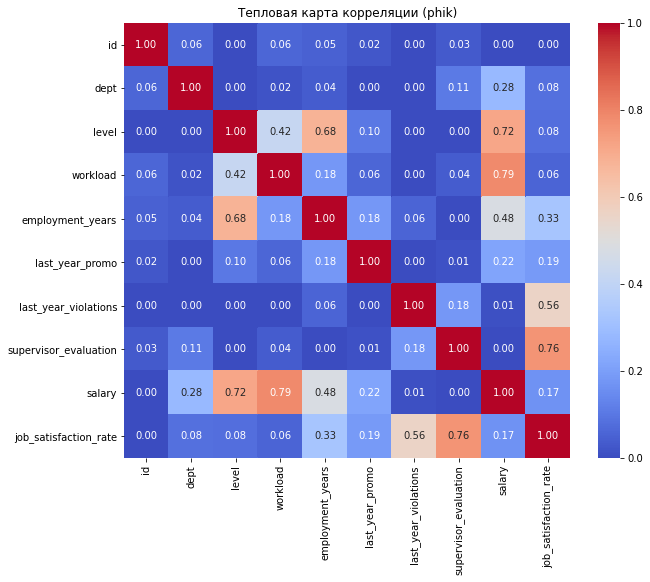


Сильной корреляции в датасете не найдено.


In [6]:
analyze_dataframe(train_job_satisfaction_rate)

In [7]:
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Обнаружены дубликаты данных (без учета столбца 'id'):


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1,hr,junior,medium,1,no,no,4,30000
2,sales,middle,low,5,no,no,4,19200
3,sales,middle,low,6,no,no,4,19200
5,purchasing,middle,medium,6,no,no,3,42000
7,sales,middle,high,9,no,no,4,49200
...,...,...,...,...,...,...,...,...
1992,sales,junior,medium,3,no,no,5,21600
1993,sales,middle,medium,8,no,no,4,38400
1995,marketing,junior,low,3,no,no,3,20400
1997,technology,junior,low,1,no,no,3,14400



Дубликатов данных (с учетом столбца 'id') не найдено.

Обнаружены пропуски данных:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary  

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Описание категориальных данных:


,dept,level,workload,last_year_promo,last_year_violations
count,1998,1999,2000,2000,2000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738



Дополнительные аспекты для беглого анализа данных:

Распределение значений в dept:


sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64


Распределение значений в level:


junior    974
middle    854
sinior    171
Name: level, dtype: int64


Распределение значений в workload:


medium    1043
low        593
high       363
             1
Name: workload, dtype: int64


Распределение значений в last_year_promo:


no     1937
yes      63
Name: last_year_promo, dtype: int64


Распределение значений в last_year_violations:


no     1738
yes     262
Name: last_year_violations, dtype: int64


Корреляция между признаками (phik):
interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary']


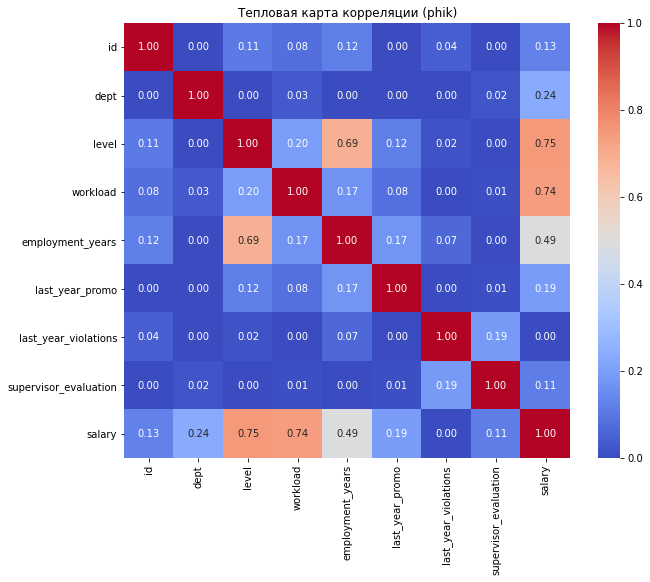


Сильной корреляции в датасете не найдено.


In [8]:
analyze_dataframe(test_features)

In [9]:
test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



Обнаружены дубликаты данных (без учета столбца 'id'):


,job_satisfaction_rate
0,0.74
1,0.75
2,0.60
3,0.72
4,0.08
...,...
1995,0.28
1996,0.21
1997,0.39
1998,0.26



Дубликатов данных (с учетом столбца 'id') не найдено.

Пропусков данных не найдено.

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

Описание количественных данных:


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000



Категориальных данных в DataFrame не найдено.

Дополнительные аспекты для беглого анализа данных:

Корреляция между признаками (phik):
interval columns not set, guessing: ['id', 'job_satisfaction_rate']


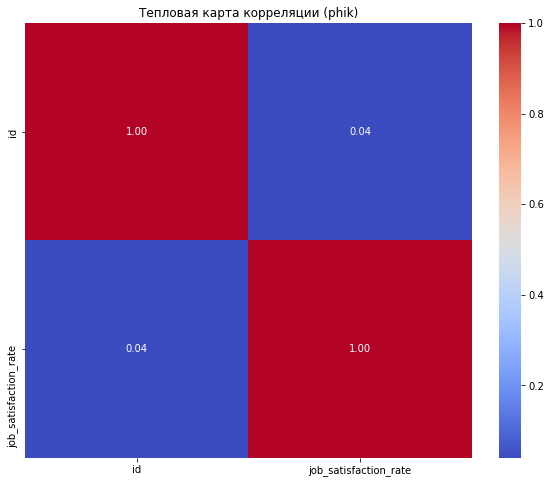


Сильной корреляции в датасете не найдено.


In [10]:
analyze_dataframe(test_target_job_satisfaction_rate)

1. **Общая Информация:**
   - Дубликатов данных не обнаружено.
   - Пропуски данных присутствуют в столбцах `dept`, `level` (6 и 4 соответственно)
   - Общий объем данных: 2000 записей.

2. **Описание Количественных Данных:**
   - Сотрудники в выборке имеют разнообразный опыт работы (от 1 до 10 лет).
   - Оценки качества работы руководителя колеблются от 1 до 5.
   - Зарплаты варьируются от 12000 до 96000.

Далее более подробно посмотрим на данные используя методы визуализации


#### Анализ количественных данных

In [11]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


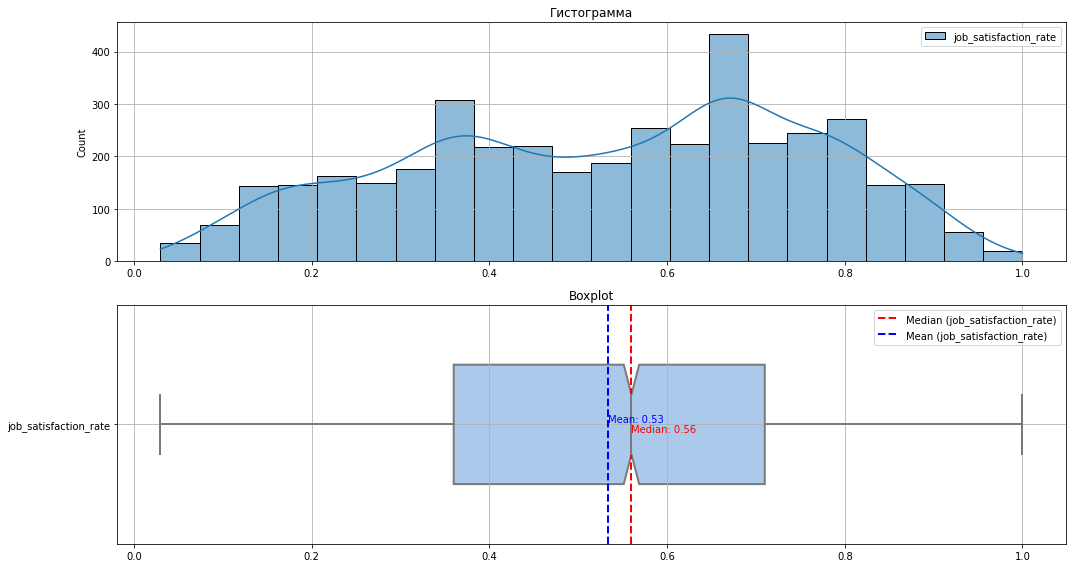

In [12]:
plot_distribution_summary(train_job_satisfaction_rate, 'job_satisfaction_rate')

Тут у нас все хорошо, выбросов нет

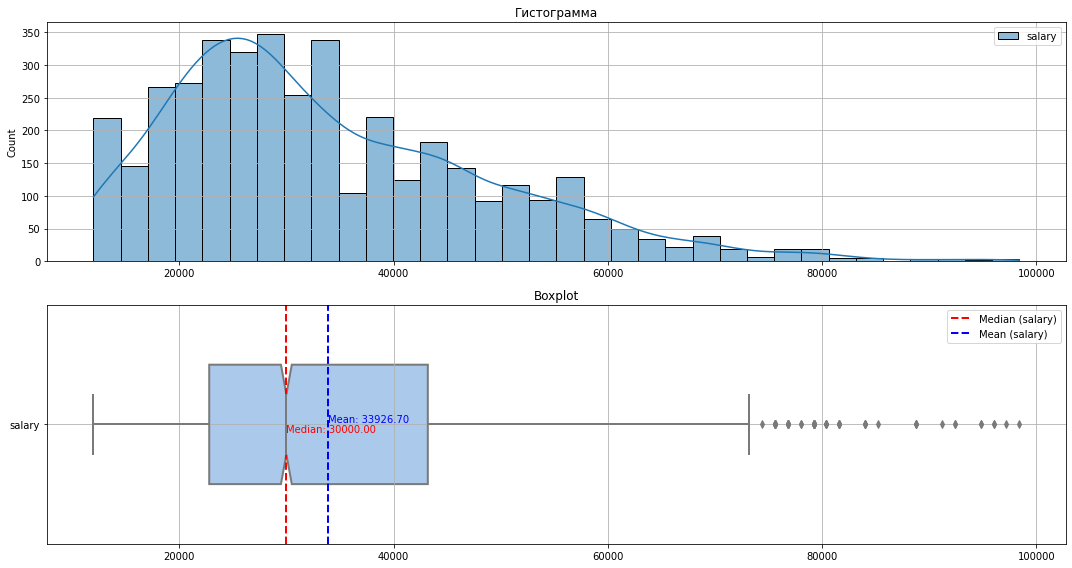

In [13]:
plot_distribution_summary(train_job_satisfaction_rate, 'salary')

Видим, что распределение скошенное вправо и имеются небольшие выбросы

In [14]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


### Категориальные признаки

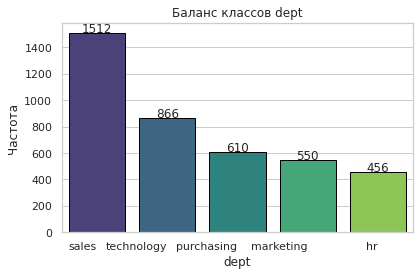

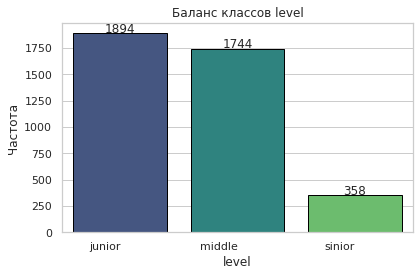

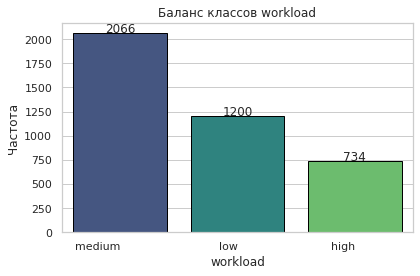

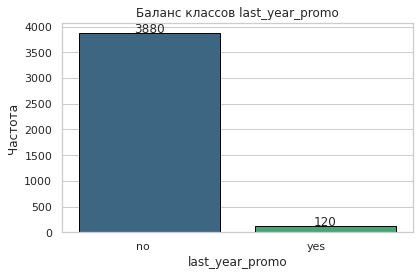

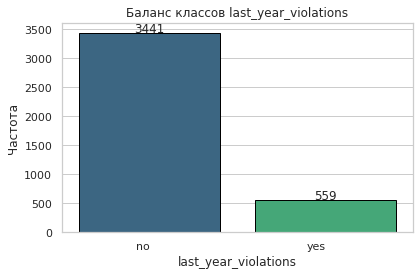

In [15]:
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    enhanced_bar_plot(train_job_satisfaction_rate, i)

   - В `dept` присутствует 5 уникальных отделов, преобладает отдел `sales`.
   - Уровень `junior` является самым распространенным в `level`.
   - В `workload` большинство сотрудников оценено как `medium`. Есть ' ' пустой символ(1 шт) далее заменим на NaN и обработаем используя `SimpleImputer`
   - `last_year_promo` говорит о том, что большинство сотрудников не получало повышение в последний год.
   - `last_year_violations` показывает, что большинство сотрудников не нарушало трудовой договор в последний год.

**Вывод:**
Можно сказать, что: `sales` - самый частый отдел, `junior` - наиболее распространенный уровень и `medium` - наиболее часто встречающийся уровень загруженности. И большинство сотрудников не получало повышение и не нарушало трудовой договор в последний год.

Теперь проверим, что тестовая выборка из того же распределения, что и обучающая. Для более убедительности проведем тест Колмогорова-Смирнова

In [16]:
def check_distribution(data_one, data_two):
    statistic, p_value = ks_2samp(data_one, data_two)

    print(f"Статистика теста: {statistic}")
    print(f"P-value: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: Распределения различаются.")
    else:
        print("Нет оснований отвергать нулевую гипотезу: Распределения совпадают.")

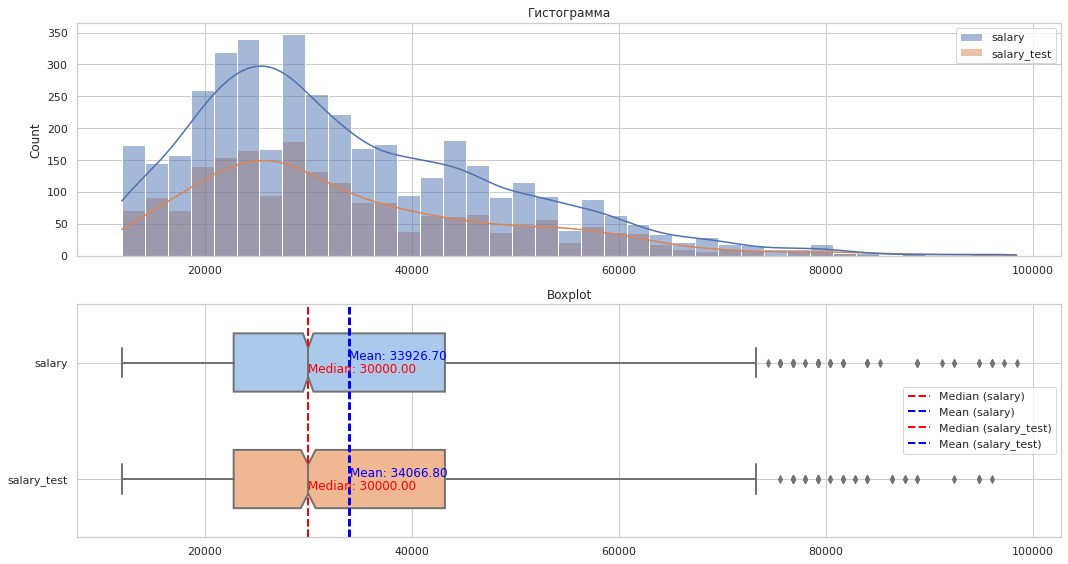

Статистика теста: 0.01775
P-value: 0.7926414953754704
Нет оснований отвергать нулевую гипотезу: Распределения совпадают.


In [17]:
test = train_job_satisfaction_rate[['salary']].copy()
test['salary_test'] = test_features['salary']
plot_distribution_summary(test, ['salary', 'salary_test'])
check_distribution(train_job_satisfaction_rate['salary'], test_features['salary'])

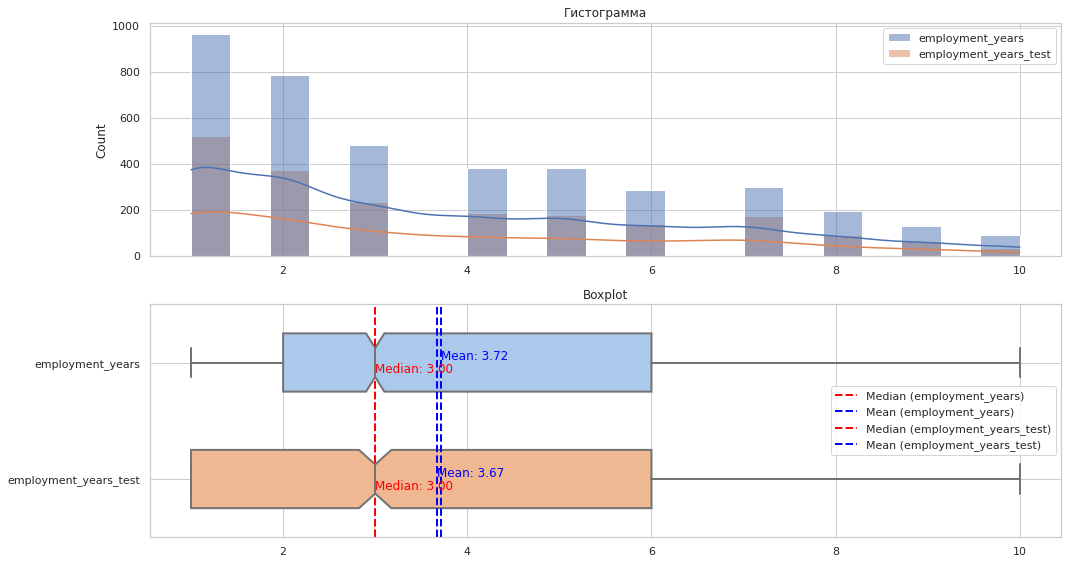

Статистика теста: 0.0195
P-value: 0.6886578851681273
Нет оснований отвергать нулевую гипотезу: Распределения совпадают.


In [18]:
test = train_job_satisfaction_rate[['employment_years']].copy()
test['employment_years_test'] = test_features['employment_years']
plot_distribution_summary(test, ['employment_years', 'employment_years_test'])
check_distribution(train_job_satisfaction_rate['employment_years'], test_features['employment_years'])

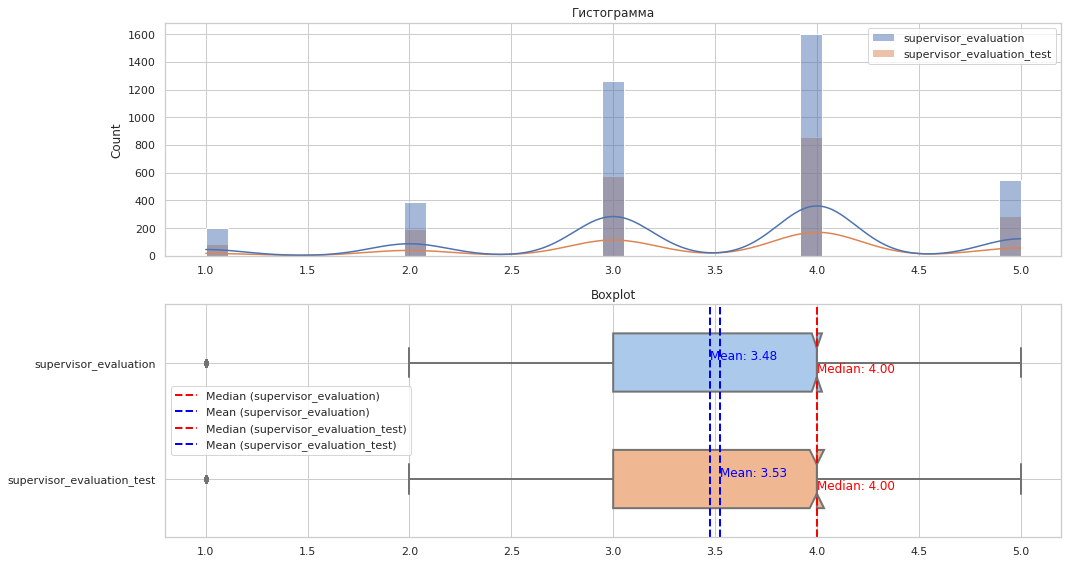

Статистика теста: 0.03325
P-value: 0.10408298363715215
Нет оснований отвергать нулевую гипотезу: Распределения совпадают.


In [19]:
test = train_job_satisfaction_rate[['supervisor_evaluation']].copy()
test['supervisor_evaluation_test'] = test_features['supervisor_evaluation']
plot_distribution_summary(test, ['supervisor_evaluation', 'supervisor_evaluation_test'])
check_distribution(train_job_satisfaction_rate['supervisor_evaluation'], test_features['supervisor_evaluation'])

In [20]:
columns_of_interest = ["level", "dept", "last_year_promo", "last_year_violations"]

for i, col in enumerate(columns_of_interest):
    print('*'*36)
    print(f'Признак: {col}')
    contingency_table = pd.crosstab(train_job_satisfaction_rate[columns_of_interest[i]], test_features[columns_of_interest[i]])

    # Проведение теста Хи-квадрат
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    # Вывод результатов теста
    print(f"Статистика Хи-квадрат: {chi2_stat}")
    print(f"P-value: {p_value}")
    print(f"Степени свободы: {dof}")
    print("Ожидаемые частоты:")
    print(expected)

    # Проверка уровня значимости
    alpha = 0.05
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: Есть статистически значимые различия в распределении.")
    else:
        print("Нет оснований отвергать нулевую гипотезу: Распределения совпадают.")

************************************
Признак: level
Статистика Хи-квадрат: 1.653035078255439
P-value: 0.799230116274028
Степени свободы: 4
Ожидаемые частоты:
[[459.67334669 402.09619238  80.23046092]
 [428.93086172 375.20440882  74.86472946]
 [ 85.39579158  74.6993988   14.90480962]]
Нет оснований отвергать нулевую гипотезу: Распределения совпадают.
************************************
Признак: dept
Статистика Хи-квадрат: 24.48259854601612
P-value: 0.2219465511310669
Степени свободы: 20
Ожидаемые частоты:
[[1.06766917e-01 2.42360902e+01 2.95744361e+01 2.91473684e+01
  8.13563910e+01 4.85789474e+01]
 [1.44360902e-01 3.27699248e+01 3.99879699e+01 3.94105263e+01
  1.10003008e+02 6.56842105e+01]
 [1.45363409e-01 3.29974937e+01 4.02656642e+01 3.96842105e+01
  1.10766917e+02 6.61403509e+01]
 [3.83458647e-01 8.70451128e+01 1.06218045e+02 1.04684211e+02
  2.92195489e+02 1.74473684e+02]
 [2.20050125e-01 4.99513784e+01 6.09538847e+01 6.00736842e+01
  1.67678195e+02 1.00122807e+02]]
Нет оснований

Отлично! Можно сказать, что данные пришли из одного и того же распредления. Теперь проверим тест

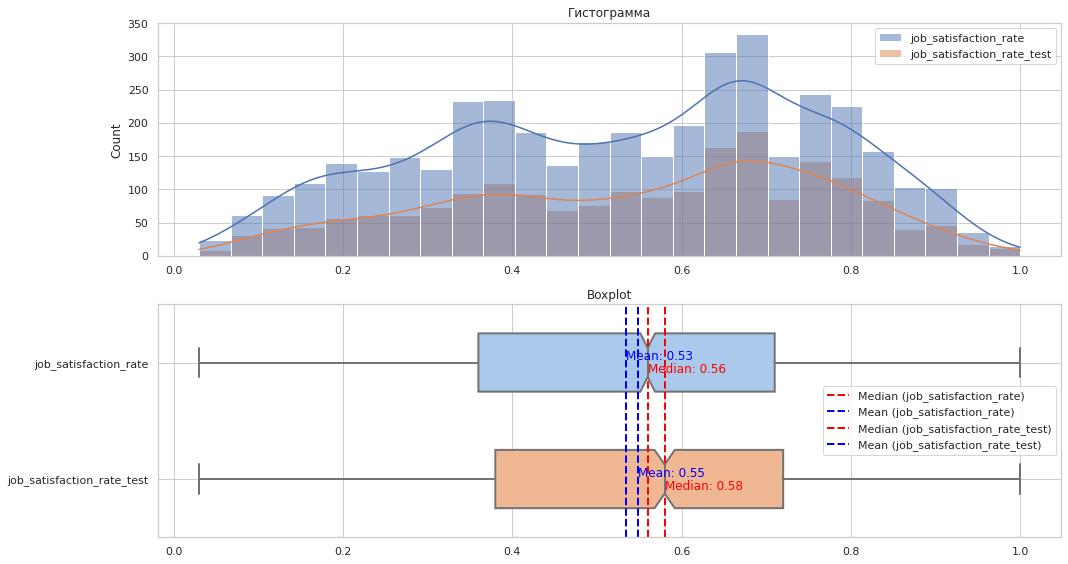

Статистика теста: 0.03875
P-value: 0.036155142461284866
Отвергаем нулевую гипотезу: Распределения различаются.


In [21]:
test = train_job_satisfaction_rate[['job_satisfaction_rate']].copy()
test['job_satisfaction_rate_test'] = test_target_job_satisfaction_rate['job_satisfaction_rate']
plot_distribution_summary(test, ['job_satisfaction_rate', 'job_satisfaction_rate_test'])
check_distribution(train_job_satisfaction_rate['job_satisfaction_rate'], test_target_job_satisfaction_rate['job_satisfaction_rate'])

Отклонение нулевой гипотезы говорит о том, что существует статистически значимое различие между двумя распределениями. Это может быть важным сигналом, что модель, обученная на train данных, может не так хорошо обобщать на новые данные (test данные) из-за различий в распределениях.

Далее обучим различные моменты и посмотрим, как модели будут справляться с нашими данными

In [23]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop(columns=['id'], axis=1).drop_duplicates()
train_job_satisfaction_rate.duplicated().sum()

0

In [24]:
feature = train_job_satisfaction_rate.drop(columns=['job_satisfaction_rate'], axis=1)
target = train_job_satisfaction_rate['job_satisfaction_rate']

In [25]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ordinal_columns = ['level', 'workload']
numeric_columns = ['salary', 'employment_years', 'supervisor_evaluation',]

Реализуем нашу метрику SMAPE:

In [26]:
def smape(y_true, y_pred):
    """
    Рассчитывает симметричное среднее абсолютное процентное отклонение (SMAPE).

    Параметры:
    - y_true: фактические значения
    - y_pred: предсказанные значения

    Возвращает:
    - SMAPE (число)
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2

    denominator[denominator == 0] = np.nan

    smape_value = np.nanmean((numerator / denominator) * 100)
    return smape_value

smape_scorer = make_scorer(smape, greater_is_better=False)

In [27]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   3749 non-null   object
 1   level                  3751 non-null   object
 2   workload               3755 non-null   object
 3   employment_years       3755 non-null   int64 
 4   last_year_promo        3755 non-null   object
 5   last_year_violations   3755 non-null   object
 6   supervisor_evaluation  3755 non-null   int64 
 7   salary                 3755 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 264.0+ KB


### LinearRegression

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat_ohe', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), ohe_columns),
        ('cat_ord', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), ordinal_columns)
        
    ], remainder='drop')

pipeline_linear = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [32]:
smape_linear = abs(cross_val_score(pipeline_linear, feature, target, cv=5, scoring=smape_scorer).mean())
print(f"Model: LinearRegression, SMAPE: {smape_linear:.4f}")

Model: LinearRegression, SMAPE: 26.8052


### LGBMRegressor

При настройке гиперпараметров для LGBMRegressor, помимо `max_depth` и `n_estimators`, которые вы уже включили в параметры для попыток оптимизации, есть и другие гиперпараметры, которые могут влиять на качество модели. Вот некоторые из них:

1. **learning_rate**: Скорость обучения. Этот параметр контролирует величину обновлений весов на каждом шаге градиентного спуска. Низкая скорость обучения может помочь в сходимости, но может потребовать больше итераций.
2. **subsample**: Доля наблюдений, используемых для обучения каждого дерева. Значение от 0 до 1. Может использоваться для борьбы с переобучением.
3. **colsample_bytree**: Доля признаков, используемых для обучения каждого дерева. Значение от 0 до 1. Также может помочь в борьбе с переобучением.
4. **reg_alpha** и **reg_lambda**: L1 и L2 регуляризация соответственно. Могут быть использованы для контроля сложности модели.
5. **num_leaves**: Максимальное количество листьев в дереве.

In [34]:
pipeline_light = Pipeline([
    ('preprocessor', preprocessor),
    ('light', LGBMRegressor(random_state=42))
])

In [35]:
params = {
    'light__max_depth': optuna.distributions.IntDistribution(2, 20),
    'light__n_estimators': optuna.distributions.IntDistribution(10, 100),
    'light__learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'light__subsample': optuna.distributions.FloatDistribution(0.5, 1),
    'light__colsample_bytree': optuna.distributions.FloatDistribution(0.5, 1),
    'light__reg_alpha': optuna.distributions.FloatDistribution(1e-8, 1),
    'light__reg_lambda': optuna.distributions.FloatDistribution(1e-8, 1),
    'light__min_child_samples': optuna.distributions.IntDistribution(5, 30),
    'light__min_child_weight': optuna.distributions.FloatDistribution(1e-3, 10),
    'light__num_leaves': optuna.distributions.IntDistribution(10, 100),
    'light__gamma': optuna.distributions.FloatDistribution(1e-8, 1)
}



optuna_light_regressor = optuna.integration.OptunaSearchCV(pipeline_light, params, n_trials=600, cv=5, n_jobs=-1,
                                                 scoring=smape_scorer, verbose=3)

optuna_light_regressor.fit(feature, target);
clear_output(wait=True)
print("Обучение завершено!!!")
print(f"SMAPE: {abs(optuna_light_regressor.best_score_):.4f}, params: {optuna_light_regressor.best_params_}")

Обучение завершено!!!
SMAPE: 11.8136, params: {'light__max_depth': 14, 'light__n_estimators': 93, 'light__learning_rate': 0.0981583013642658, 'light__subsample': 0.6686425171214645, 'light__colsample_bytree': 0.8743194290324279, 'light__reg_alpha': 0.0010256716103732091, 'light__reg_lambda': 0.2948187959759771, 'light__min_child_samples': 5, 'light__min_child_weight': 3.1341640068249896, 'light__num_leaves': 58, 'light__gamma': 0.7267068737066315}


**Параметры:**
- `max_depth`: 14
- `n_estimators`: 93
- `learning_rate`: 0.0981583013642658
- `subsample`: 0.6686425171214645
- `colsample_bytree`: 0.8743194290324279
- `reg_alpha`: 0.0010256716103732091
- `reg_lambda`: 0.2948187959759771
- `min_child_samples`: 5
- `min_child_weight`: 3.1341640068249896
- `num_leaves`: 58
- `gamma`: 0.7267068737066315






**SMAPE**: 11.8136

In [36]:
params_decision_tree = {
    'decision_tree__max_depth': optuna.distributions.IntDistribution(2, 100),
    'decision_tree__min_samples_split': optuna.distributions.IntDistribution(2, 100),
    'decision_tree__min_samples_leaf': optuna.distributions.IntDistribution(1, 100),
}

pipeline_decision_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('decision_tree', DecisionTreeRegressor(random_state=42))
])

# Использование Optuna для поиска оптимальных гиперпараметров
optuna_decision_tree_regressor = optuna.integration.OptunaSearchCV(
    pipeline_decision_tree, params_decision_tree, n_trials=300, cv=5, n_jobs=-1,
    scoring=smape_scorer, verbose=3
)

# Обучение модели DecisionTreeRegressor с оптимизированными гиперпараметрами
optuna_decision_tree_regressor.fit(feature, target)

# Вывод результатов
clear_output(wait=True)
print("Обучение DecisionTreeRegressor завершено!!!")
print(f"SMAPE: {abs(optuna_decision_tree_regressor.best_score_):.4f}, params: {optuna_decision_tree_regressor.best_params_}")

Обучение DecisionTreeRegressor завершено!!!
SMAPE: 15.3820, params: {'decision_tree__max_depth': 28, 'decision_tree__min_samples_split': 11, 'decision_tree__min_samples_leaf': 1}


#### Тестирование

In [37]:
best_params_regressor = {'light__max_depth': 14,
                         'light__n_estimators': 93,
                         'light__learning_rate': 0.0981583013642658,
                         'light__subsample': 0.6686425171214645,
                         'light__colsample_bytree': 0.8743194290324279,
                         'light__reg_alpha': 0.0010256716103732091,
                         'light__reg_lambda': 0.2948187959759771,
                         'light__min_child_samples': 5, 
                         'light__min_child_weight': 3.1341640068249896,
                         'light__num_leaves': 58, 
                         'light__gamma': 0.7267068737066315}

pipeline_light.set_params(**best_params_regressor)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['salary', 'employment_years',
                                                   'supervisor_evaluation']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('cat_ord',
                                                  Pipe...
                                                  ['level', 'workload'])])),
                ('light',
                 LGBMRegressor(colsample_bytree=0.8743194290324279,
                               gamma=0.7267068737066315,
                               learning_rate=0.0981583013642658, max_depth=14,
                               min_child_samples=5,
                               min_child_weight=3.1341640068249896,
                               n_estimators=93, num_leaves=58, random_state=42,
                               reg_alpha=0.0010256716103732091,
                               reg_lambda=0.2948187959759771,
                               subsample=0.6686425171214645))])

In [38]:
pipeline_light.fit(feature, target)
clear_output()

In [39]:
test_features['predict'] = pipeline_light.predict(test_features)
final_predict = pd.merge(test_features, test_target_job_satisfaction_rate, on='id')[['predict', 'job_satisfaction_rate']]

[LightGBM] [Warning] Unknown parameter: gamma


In [40]:
smape_test_regressor = smape(final_predict['job_satisfaction_rate'], final_predict['predict'])
print(f"SMAPE on test: {smape_test_regressor:.4f}")

SMAPE on test: 10.8565


Исходя из предоставленной информации о задаче и проведенных анализах, мы можем сделать следующие выводы:

1. Задачи:
   - Столкнулись с задачей построения модели для прогнозирования уровня удовлетворенности сотрудника на основе данных заказчика.
   - Также у нас есть задача по построению модели для прогнозирования увольнения сотрудника из компании.

2. Анализ данных:
   - Обнаружили пропуски данных в столбцах `dept` и `level`, которые потребовали обработки.
   - В категориальных данных преобладают следующие значения:
     - Отдел: `sales`
     - Уровень: `junior`
     - Уровень загруженности: `medium`
     - Большинство сотрудников не получали повышение и не нарушали трудовой договор в последний год.

3. Предобработка данных:
   - применили Pipeline для обработки данных, включая стандартизацию числовых признаков, замену пропусков и кодирование категориальных признаков.
   - использовали разные стратегии для обработки пропусков: `SimpleImputer(strategy='most_frequent')` для категориальных признаков и `SimpleImputer(strategy='mean')` для числовых.
   - Категориальные признаки были закодированы с использованием OneHotEncoder для номинальных и OrdinalEncoder для порядковых признаков.

4. Обучение моделей:
   - использовали разные модели, включая LinearRegression, DecisionTreeRegressor и LGBMRegressor, с настройкой гиперпараметров.
   - Для оценки качества моделей мы использовали кросс-валидацию с метрикой SMAPE (Symmetric Mean Absolute Percentage Error).

5. Результаты:
   - Лучшие параметры для LGBMRegressor были подобраны, и модель показала хороший результат на кросс-валидации с SMAPE около 11.8136.
   - Модель DecisionTreeRegressor также была обучена, но ее качество оказалось ниже с SMAPE около 15.3820.
   - На тестовых данных LGBMRegressor показала SMAPE около 10.8565.

В целом, модель LGBMRegressor демонстрирует лучшее качество предсказания по сравнению с DecisionTreeRegressor, и она может быть рекомендована для использования в задачах прогнозирования уровня удовлетворенности сотрудников и их увольнения из компании.

## Задача 2: Предсказание увольнения сотрудника из компании

### Шаг 1: Загрузка данных

Загрузим данные из файлов:

#### Тренировочная выборка:
- [train_quit.csv](https://code.s3.yandex.net/datasets/train_quit.csv)

#### Входные признаки тестовой выборки (те же, что и в предыдущей задаче):
- [test_features.csv](https://code.s3.yandex.net/datasets/test_features.csv)

#### Целевой признак тестовой выборки:
- [test_target_quit.csv](https://code.s3.yandex.net/datasets/test_target_quit.csv)

### Шаг 2: Предобработка данных

Изучим данные и при необходимости выполним предобработку. Если есть пропуски, заполним их в пайплайне.

### Шаг 3: Исследовательский анализ данных

#### 3.1 Исследовательский анализ данных
Проведем анализ данных, чтобы лучше понять характеристики датасета.

#### 3.2 Портрет "уволившегося сотрудника"
Определим, какие признаки с большей вероятностью характеризуют уволившихся сотрудников. Сравним отделы, уровень загруженности и зарплаты.

#### 3.3 Влияние уровня удовлетворённости на увольнение
Проверим утверждение, что уровень удовлетворённости влияет на увольнение. Визуализируем распределения признака `job_satisfaction_rate` для уволившихся и оставшихся сотрудников.

### Шаг 4: Добавление нового входного признака

Допустим, что `job_satisfaction_rate` и `quit` связаны. Добавим предсказанный `job_satisfaction_rate` из лучшей модели первой задачи к входным признакам второй задачи.

### Шаг 5: Подготовка данных

Подготовим признаки аналогично первой задаче, выполним подготовку в пайплайне, используя несколько кодировщиков.

### Шаг 6: Обучение модели

Обучим как минимум три модели. Подберем гиперпараметры для как минимум двух из них. Проверим качество лучшей модели с использованием ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке.

In [41]:
train_employee_turnover = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
train_employee_turnover.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



Обнаружены дубликаты данных (без учета столбца 'id'):


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,sales,middle,high,2,no,no,4,54000,no
1,sales,junior,medium,2,no,no,4,27600,no
2,purchasing,middle,medium,5,no,no,1,37200,no
3,sales,junior,medium,2,no,yes,3,24000,yes
8,marketing,middle,low,7,no,no,4,25200,no
...,...,...,...,...,...,...,...,...,...
3990,sales,junior,low,3,no,no,4,12000,no
3993,marketing,middle,medium,5,no,no,3,44400,no
3995,sales,junior,medium,4,no,no,3,26400,no
3996,sales,middle,high,9,no,no,4,52800,no



Дубликатов данных (с учетом столбца 'id') не найдено.

Пропусков данных не найдено.

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

Описание количественных данных:


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000



Описание категориальных данных:


,dept,level,workload,last_year_promo,last_year_violations,quit
count,4000,4000,4000,4000,4000,4000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,1438,1949,2118,3887,3455,2872



Дополнительные аспекты для беглого анализа данных:

Распределение значений в dept:


dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64


Распределение значений в level:


level
junior    1949
middle    1694
sinior     357
Name: count, dtype: int64


Распределение значений в workload:


workload
medium    2118
low       1208
high       674
Name: count, dtype: int64


Распределение значений в last_year_promo:


last_year_promo
no     3887
yes     113
Name: count, dtype: int64


Распределение значений в last_year_violations:


last_year_violations
no     3455
yes     545
Name: count, dtype: int64


Распределение значений в quit:


quit
no     2872
yes    1128
Name: count, dtype: int64


Корреляция между признаками (phik):
interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary']


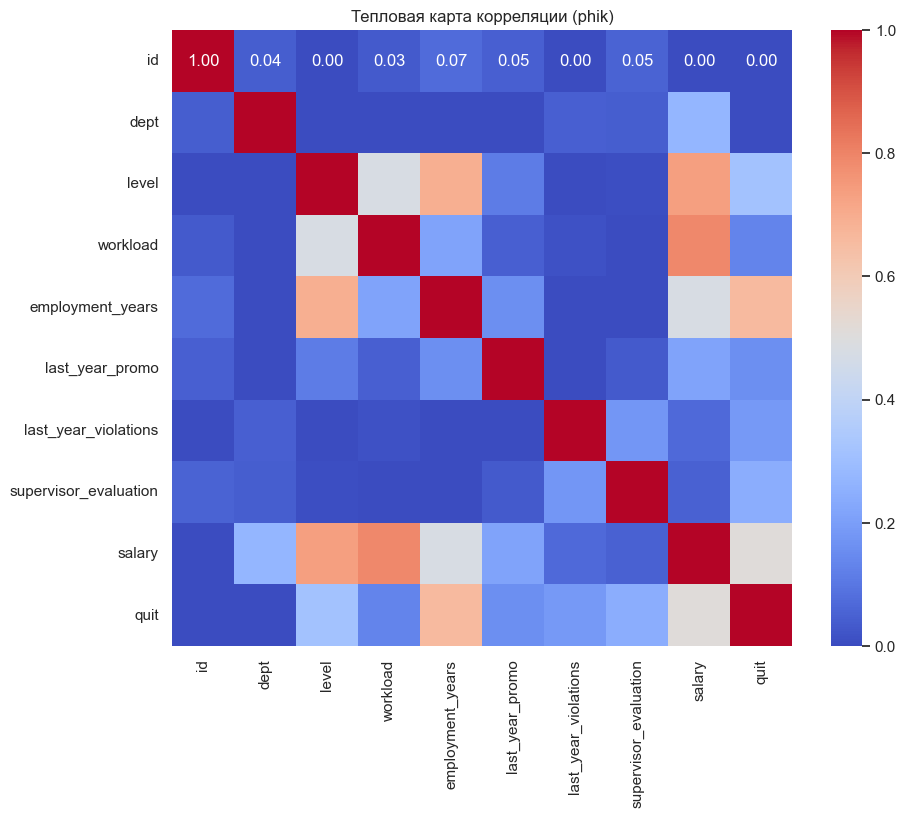


Сильной корреляции в датасете не найдено.


In [42]:
analyze_dataframe(train_employee_turnover)

В общем, данные выглядят в порядке: нет дубликатов и пропусков.

#### Количественные данные:
- `employment_years:` Среднее значение стажа работы составляет примерно 5.5 лет, с минимальным стажем 1 год и максимальным - 10 лет.
- `supervisor_evaluation:` Средняя оценка руководителя около 3.7 из 5.
- `salary:` Заработная плата варьируется от 12000 до 96000, среднее значение около 33805.

#### Категориальные данные:
- `dept (отдел):` Преобладающий отдел - sales, затем technology, purchasing, marketing, и hr.
- `level (уровень):` Большинство сотрудников - junior, затем middle и senior.
- `workload (нагрузка):` Большинство сотрудников имеют среднюю нагрузку, затем низкую и высокую.
- `last_year_promo (повышение в прошлом году):` Большинство сотрудников не получили повышение в прошлом году.
- `last_year_violations (наличие нарушений в прошлом году):` Большинство сотрудников не имели нарушений в прошлом году.
- `quit (увольнение):` Примерно 28.7% сотрудников уволились.

---

- `Распределение отделов:` Преобладающий отдел - sales.
- `Распределение уровней:` Большинство сотрудников - junior.
- `Распределение нагрузки:` Большинство имеют среднюю нагрузку.
- `Распределение повышений в прошлом году:` Большинство сотрудников не получили повышение.
- `Распределение нарушений в прошлом году:` Большинство сотрудников не имели нарушений.
- `Распределение увольнений:` Примерно 28.7% сотрудников уволились.

In [43]:
test_features_turnover = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_features_turnover.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Обнаружены дубликаты данных (без учета столбца 'id'):


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1,hr,junior,medium,1,no,no,4,30000
2,sales,middle,low,5,no,no,4,19200
3,sales,middle,low,6,no,no,4,19200
5,purchasing,middle,medium,6,no,no,3,42000
7,sales,middle,high,9,no,no,4,49200
...,...,...,...,...,...,...,...,...
1992,sales,junior,medium,3,no,no,5,21600
1993,sales,middle,medium,8,no,no,4,38400
1995,marketing,junior,low,3,no,no,3,20400
1997,technology,junior,low,1,no,no,3,14400



Дубликатов данных (с учетом столбца 'id') не найдено.

Обнаружены пропуски данных:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary  

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Описание категориальных данных:


,dept,level,workload,last_year_promo,last_year_violations
count,1998,1999,2000,2000,2000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738



Дополнительные аспекты для беглого анализа данных:

Распределение значений в dept:


dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: count, dtype: int64


Распределение значений в level:


level
junior    974
middle    854
sinior    171
Name: count, dtype: int64


Распределение значений в workload:


workload
medium    1043
low        593
high       363
             1
Name: count, dtype: int64


Распределение значений в last_year_promo:


last_year_promo
no     1937
yes      63
Name: count, dtype: int64


Распределение значений в last_year_violations:


last_year_violations
no     1738
yes     262
Name: count, dtype: int64


Корреляция между признаками (phik):
interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary']


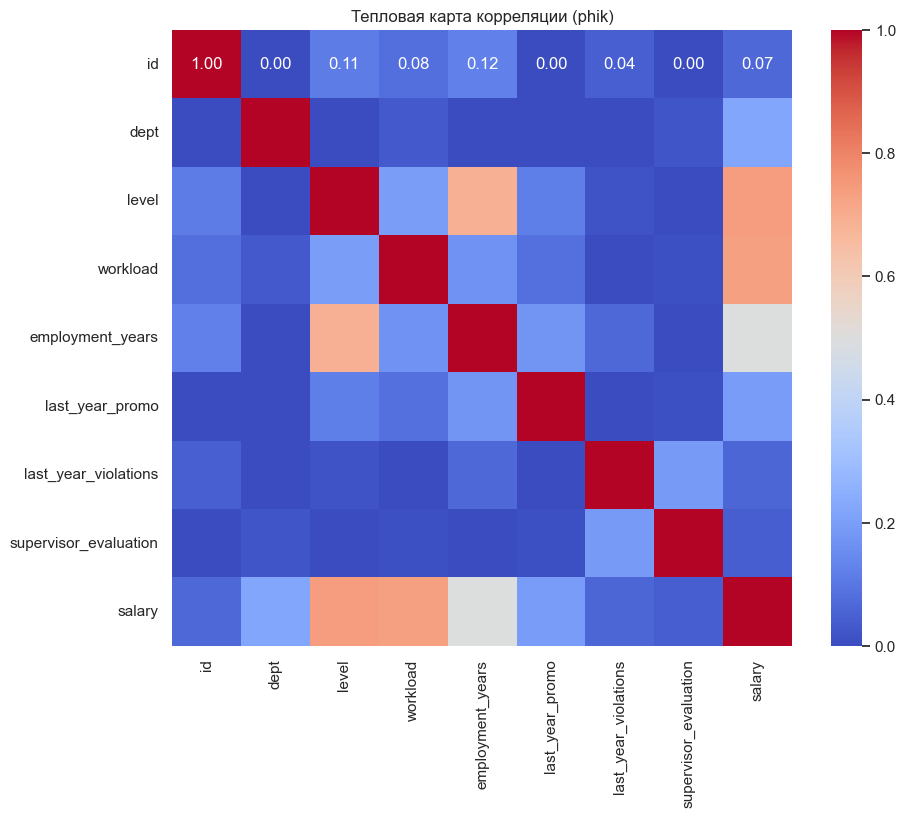


Сильной корреляции в датасете не найдено.


In [44]:
analyze_dataframe(test_features_turnover)

Данные содержат некоторые пропущенные значения, особенно в столбцах `dept` и `level`. Перед приступлением к анализу следует решить проблему с пропущенными данными, возможно, путем заполнения или удаления соответствующих строк. Кроме того, обнаруженные распределения могут дать представление о структуре компании и ее сотрудниках.

In [45]:
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



Обнаружены дубликаты данных (без учета столбца 'id'):


,quit
0,yes
1,no
2,no
3,no
4,yes
...,...
1995,yes
1996,yes
1997,no
1998,no



Дубликатов данных (с учетом столбца 'id') не найдено.

Пропусков данных не найдено.

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

Описание количественных данных:


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000



Описание категориальных данных:


,quit
count,2000
unique,2
top,no
freq,1436



Дополнительные аспекты для беглого анализа данных:

Распределение значений в quit:


quit
no     1436
yes     564
Name: count, dtype: int64


Корреляция между признаками (phik):
interval columns not set, guessing: ['id']


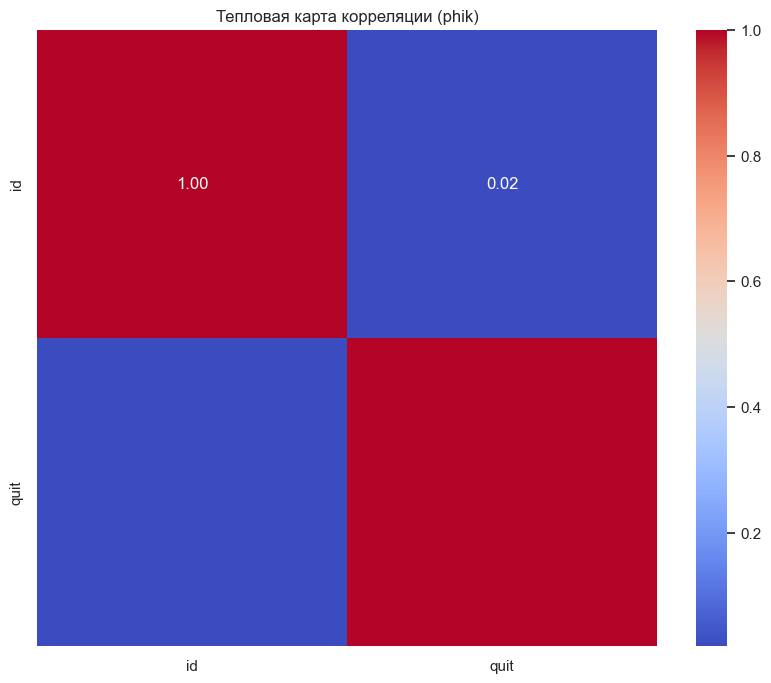


Сильной корреляции в датасете не найдено.


In [46]:
analyze_dataframe(test_target_quit)

### Шаг 3. Исследовательский анализ данных

#### Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании

In [47]:
train_employee_turnover.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [48]:
result_dept = (train_employee_turnover.pivot_table(index='dept', columns='quit', aggfunc='size', fill_value=0)
          .div(train_employee_turnover.groupby('dept').size(), axis=0)
          .reset_index()
          .rename_axis(None, axis=1)
          .melt(id_vars='dept', var_name='quit', value_name='percentage'))
result_dept

,dept,quit,percentage
0,hr,no,0.750000
1,marketing,no,0.719931
2,purchasing,no,0.717687
3,sales,no,0.716968
4,technology,no,0.702586
5,hr,yes,0.250000
6,marketing,yes,0.280069
7,purchasing,yes,0.282313
8,sales,yes,0.283032
9,technology,yes,0.297414


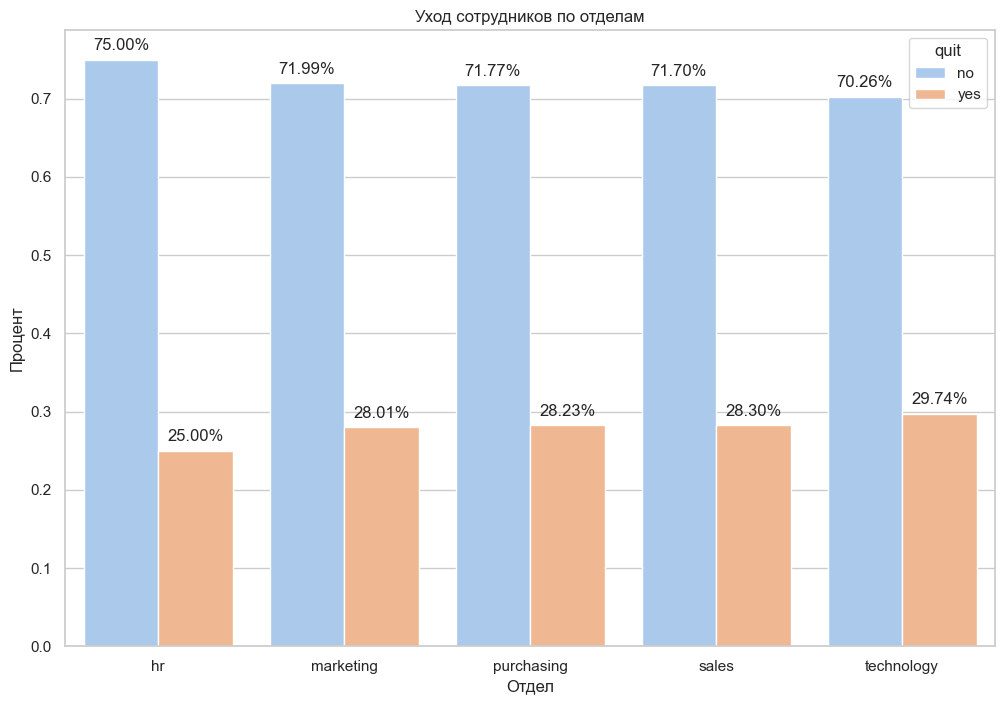

In [49]:
plt.figure(figsize=(12, 8))
sns.set_palette("pastel")
ax = sns.barplot(x='dept', y='percentage', hue='quit', data=result_dept)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Уход сотрудников по отделам')
plt.xlabel('Отдел')
plt.ylabel('Процент')
plt.show()


Можно заметить, что наибольшее кол-во увольнений в `technology`, самыми удволетворенными в компании являются сотрудники отдела `hr`

In [50]:
result_workload = (train_employee_turnover.pivot_table(index='workload', columns='quit', aggfunc='size', fill_value=0)
          .div(train_employee_turnover.groupby('workload').size(), axis=0)
          .reset_index()
          .rename_axis(None, axis=1)
          .melt(id_vars='workload', var_name='quit', value_name='percentage'))
result_workload

,workload,quit,percentage
0,high,no,0.820475
1,low,no,0.570364
2,medium,no,0.769594
3,high,yes,0.179525
4,low,yes,0.429636
5,medium,yes,0.230406


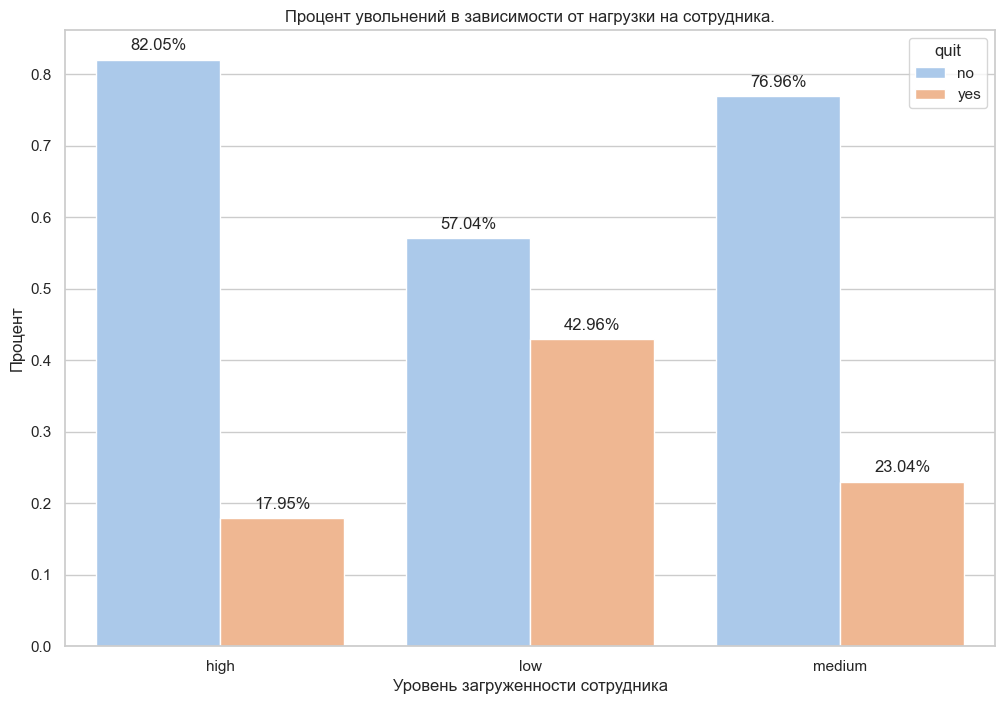

In [51]:
plt.figure(figsize=(12, 8))
sns.set_palette("pastel")
ax = sns.barplot(x='workload', y='percentage', hue='quit', data=result_workload)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Процент увольнений в зависимости от нагрузки на сотрудника.')
plt.xlabel('Уровень загруженности сотрудника')
plt.ylabel('Процент')
plt.show()


можно сделать следующие выводы:

1. **Высокая загруженность:**
   - Процент увольнений: 17.95%
   - Процент оставшихся: 82.05%

2. **Средняя загруженность:**
   - Процент увольнений: 23.04%
   - Процент оставшихся: 76.96%

3. **Низкая загруженность:**
   - Процент увольнений: 42.96%
   - Процент оставшихся: 57.04%

**Вывод:** Сотрудники с низкой загруженностью более склонны к увольнению, чем те, кто работает в условиях высокой или средней загруженности. Это может быть связано с различными факторами, такими как отсутствие интересных задач или недостаток возможностей для профессионального роста.

In [52]:
result_level = (train_employee_turnover.pivot_table(index='level', columns='quit', aggfunc='size', fill_value=0)
          .div(train_employee_turnover.groupby('level').size(), axis=0)
          .reset_index()
          .rename_axis(None, axis=1)
          .melt(id_vars='level', var_name='quit', value_name='percentage'))
result_level

,level,quit,percentage
0,junior,no,0.485377
1,middle,no,0.936246
2,sinior,no,0.952381
3,junior,yes,0.514623
4,middle,yes,0.063754
5,sinior,yes,0.047619


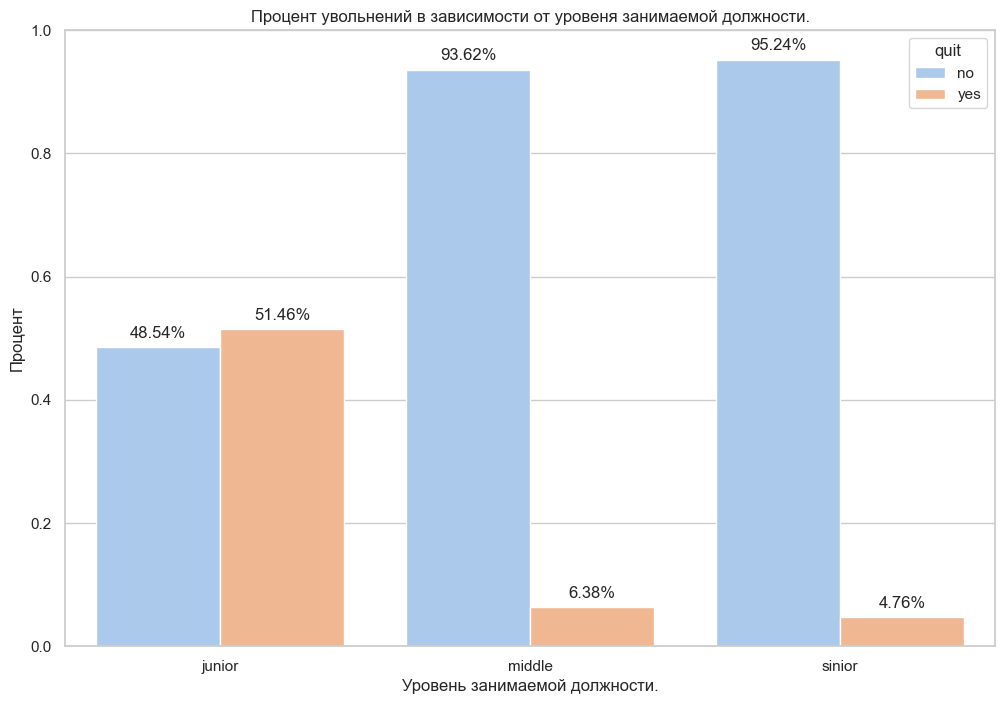

In [53]:
plt.figure(figsize=(12, 8))
sns.set_palette("pastel")
ax = sns.barplot(x='level', y='percentage', hue='quit', data=result_level)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Процент увольнений в зависимости от уровеня занимаемой должности.')
plt.xlabel('Уровень занимаемой должности.')
plt.ylabel('Процент')
plt.show()


можно сделать следующие выводы:

1. **Junior:**
   - Процент увольнений: 51.46%

2. **Middle:**
   - Процент увольнений: 6.38%

3. **Senior:**
   - Процент увольнений: 4.76%

**Вывод:** Видно, что сотрудники с более высоким уровнем (Middle и Senior) имеют значительно меньший процент увольнений по сравнению с Junior. Вероятно, это связано с тем, что более опытные сотрудники имеют более стабильные позиции, больше возможностей для профессионального роста и меньше склонны к частым сменам мест работы. Наоборот, сотрудники на начальном этапе своей карьеры (Junior) более подвержены увольнениям, возможно, из-за поиска новых возможностей и опыта.

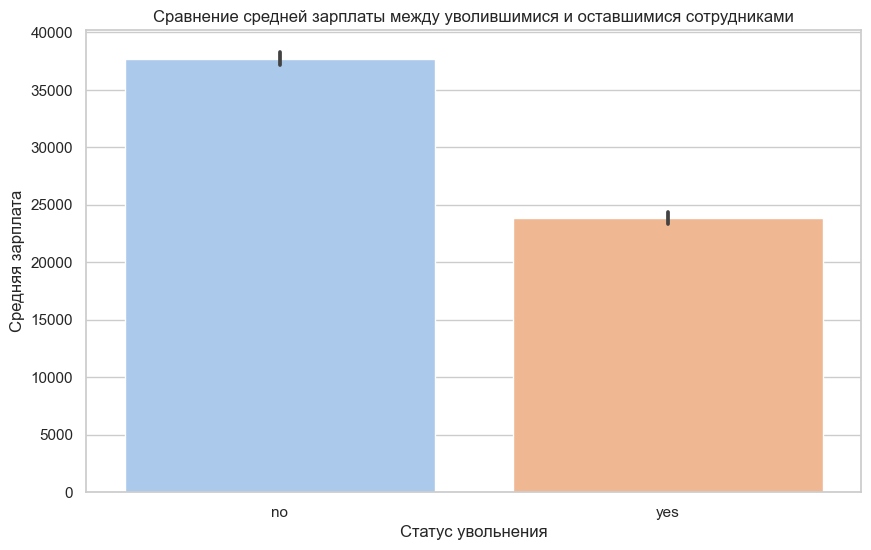

In [54]:
plt.figure(figsize=(10, 6))
sns.barplot(x='quit', y='salary', data=train_employee_turnover)
plt.title('Сравнение средней зарплаты между уволившимися и оставшимися сотрудниками')
plt.xlabel('Статус увольнения')
plt.ylabel('Средняя зарплата')
plt.show()


#### Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [55]:
test_data = pd.merge(test_target_quit, test_target_job_satisfaction_rate, on='id')

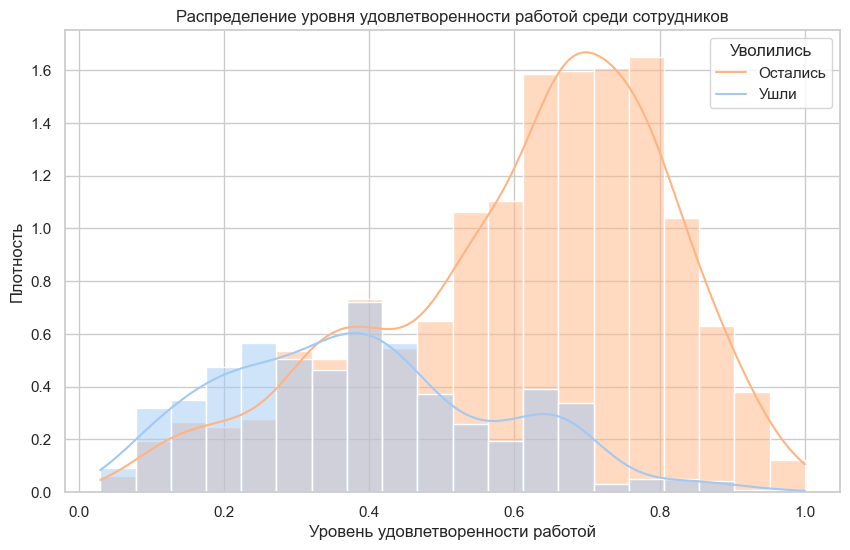

In [56]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.histplot(data=test_data, x='job_satisfaction_rate', hue='quit', kde=True, bins=20, palette='pastel', stat='density')
plt.title('Распределение уровня удовлетворенности работой среди сотрудников')
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Плотность')
plt.legend(title='Уволились', labels=['Остались', 'Ушли'])
plt.show()


Видим, что существует связь между уровнем удовлетворенности работой сотрудника в компании и вероятностью того, уйдет ли сотрудник.В дальнейшем будем использовать данную фичу для построения модели

`sns.histplot(data=test_data, x='job_satisfaction_rate', hue='quit', stat='density', common_norm=False)`

#### Шаг 4. Добавление нового входного признака

In [57]:
#train
train_employee_turnover['job_satisfaction_rate'] = pipeline_light.predict(train_employee_turnover)
#test
test_features_turnover['log_salary'] = test_features_turnover['salary']
test_features_turnover['job_satisfaction_rate'] = pipeline_light.predict(test_features_turnover)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma


In [58]:
train_employee_turnover.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.654953
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.837718
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.334839
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.327477
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.725910


#### Шаг 5-6. Подготовка данных/обучение модели

In [59]:
train_employee_turnover['quit'] = train_employee_turnover['quit'].map({'no': 0, 'yes': 1})

In [60]:
train_employee_turnover = train_employee_turnover.drop(columns=['id'], axis=1).drop_duplicates()
train_employee_turnover.duplicated().sum()

0

In [61]:
feature = train_employee_turnover.drop(columns=['quit'], axis=1)
target = train_employee_turnover['quit']

#### LogisticRegression

In [62]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ordinal_columns = ['level', 'workload']
numeric_columns = ['salary', 'employment_years', 'supervisor_evaluation','job_satisfaction_rate']

preprocessor_class = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat_ohe', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), ohe_columns),
        ('cat_ord', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), ordinal_columns)
        
    ], remainder='drop')

In [63]:
pipeline_log = Pipeline([
    ('preprocessor', preprocessor_class),
    ('model', LogisticRegression(random_state=42))
])

In [64]:
auc_log_default = abs(cross_val_score(pipeline_log, feature, target, cv=5, scoring='roc_auc').mean())
print(f"ROC AUC default: {auc_log_default:.4f}")

ROC AUC default: 0.9112


Попытаемся улучшить предсказания

In [65]:
params = {
    'model__C': optuna.distributions.FloatDistribution(1e-5, 1000),
}
optuna_log_class = optuna.integration.OptunaSearchCV(pipeline_log, params, n_trials=150, cv=5, n_jobs=-1,
                                       scoring='roc_auc', verbose=3)

optuna_log_class.fit(feature, target);
clear_output(wait=True)
print("Обучение завершено!!!")
print(f"ROC AUC: {abs(optuna_log_class.best_score_):.4f}, params: {optuna_log_class.best_params_}")

Обучение завершено!!!
ROC AUC: 0.9115, params: {'model__C': 760.5677537123288}


#### LGBMClassifier

In [66]:
pipe_light_class = Pipeline([
    ('preprocessor', preprocessor_class),
    ('light', LGBMClassifier(random_state=42))
])

In [67]:
auc_log_default = abs(cross_val_score(pipe_light_class, feature, target, cv=5, scoring='roc_auc').mean())
clear_output(wait=True)
print(f"ROC AUC default: {auc_log_default:.4f}")

ROC AUC default: 0.9062


Попытаемся улучшить предсказания

In [68]:
params = {
    'light__max_depth': optuna.distributions.IntDistribution(2, 20),
    'light__n_estimators': optuna.distributions.IntDistribution(10, 100),
    'light__learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'light__subsample': optuna.distributions.FloatDistribution(0.5, 1),
    'light__colsample_bytree': optuna.distributions.FloatDistribution(0.5, 1),
    'light__reg_alpha': optuna.distributions.FloatDistribution(1e-8, 1),
    'light__reg_lambda': optuna.distributions.FloatDistribution(1e-8, 1),
    'light__min_child_samples': optuna.distributions.IntDistribution(5, 30),
    'light__min_child_weight': optuna.distributions.FloatDistribution(1e-3, 10),
    'light__num_leaves': optuna.distributions.IntDistribution(10, 100),
    'light__gamma': optuna.distributions.FloatDistribution(1e-8, 1)
}

search_light_class = optuna.integration.OptunaSearchCV(pipe_light_class, params, n_trials=300, cv=5, n_jobs=-1,
                                       scoring='roc_auc', verbose=3)
search_light_class.fit(feature, target);
clear_output(wait=True)
print("Обучение завершено!!!")
print(f"ROC AUC: {abs(search_light_class.best_score_):.4f}, params: {search_light_class.best_params_}")

Обучение завершено!!!
ROC AUC: 0.9247, params: {'light__max_depth': 9, 'light__n_estimators': 29, 'light__learning_rate': 0.08460621605860102, 'light__subsample': 0.8353385368890922, 'light__colsample_bytree': 0.6790044221892133, 'light__reg_alpha': 0.7949823973488098, 'light__reg_lambda': 0.5158200775049875, 'light__min_child_samples': 28, 'light__min_child_weight': 4.231973394268745, 'light__num_leaves': 49, 'light__gamma': 0.17448492865113907}


Немного смогли улучшить качество:)

Итоговый ROC AUC на кросс валидации 0.9247

**Лучшие параметры**:
- `max_depth`: 9
- `n_estimators`: 29
- `learning_rate`: 0.08460621605860102
- `subsample`: 0.8353385368890922
- `colsample_bytree`: 0.6790044221892133
- `reg_alpha`: 0.7949823973488098
- `reg_lambda`: 0.5158200775049875
- `min_child_samples`: 28
- `min_child_weight`: 4.231973394268745
- `num_leaves`: 49
- `gamma`: 0.17448492865113907
8039463674



### DecisionTreeClassifier

In [69]:
pipeline_decision_tree_class = Pipeline([
    ('preprocessor', preprocessor_class),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

optuna_decision_tree_class = optuna.integration.OptunaSearchCV(
    pipeline_decision_tree_class, params_decision_tree, n_trials=600, cv=5, n_jobs=-1,
    scoring='roc_auc', verbose=3
)

optuna_decision_tree_class.fit(feature, target)

clear_output(wait=True)
print("Обучение DecisionTreeRegressor завершено!!!")
print(f"ROC AUC: {abs(optuna_decision_tree_class.best_score_):.4f}, params: {optuna_decision_tree_class.best_params_}")

Обучение DecisionTreeRegressor завершено!!!
ROC AUC: 0.9095, params: {'decision_tree__max_depth': 62, 'decision_tree__min_samples_split': 25, 'decision_tree__min_samples_leaf': 25}


#### Тестирование

In [70]:
best_params_class = {'light__max_depth': 9,
                     'light__n_estimators': 29,
                     'light__learning_rate': 0.08460621605860102,
                     'light__subsample': 0.8353385368890922,
                     'light__colsample_bytree': 0.6790044221892133, 
                     'light__reg_alpha': 0.7949823973488098, 
                     'light__reg_lambda': 0.5158200775049875, 
                     'light__min_child_samples': 28, 
                     'light__min_child_weight': 4.231973394268745,
                     'light__num_leaves': 49,
                     'light__gamma': 0.17448492865113907}

pipe_light_class.set_params(**best_params_class)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['salary', 'employment_years',
                                                   'supervisor_evaluation',
                                                   'job_satisfaction_rate']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_viola...
                                                  ['level', 'workload'])])),
                ('light',
                 LGBMClassifier(colsample_bytree=0.6790044221892133,
                                gamma=0.17448492865113907,
                                learning_rate=0.08460621605860102, max_depth=9,
                                min_child_samples=28,
                                min_child_weight=4.231973394268745,
                                n_estimators=29, num_leaves=49, random_state=42,
                                reg_alpha=0.7949823973488098,
                                reg_lambda=0.5158200775049875,
                                subsample=0.8353385368890922))])

In [71]:
pipe_light_class.fit(feature, target)
clear_output()

In [72]:
test_target_quit['quit'] = test_target_quit['quit'].map({'no': 0, 'yes': 1})
test_target_quit.head()

,id,quit
0,999029,1
1,372846,0
2,726767,0
3,490105,0
4,416898,1


In [73]:
test_features_turnover['predict_proba'] = search_light_class.predict_proba(test_features_turnover)[:, 1]
final_predict_class = pd.merge(test_features_turnover, test_target_quit, on='id')[['predict_proba', 'quit']]
final_predict_class.head()

[LightGBM] [Warning] Unknown parameter: gamma


,predict_proba,quit
0,0.192100,0
1,0.292923,0
2,0.080469,0
3,0.075875,0
4,0.052823,0


In [74]:
print(f"ROC AUC on test: {roc_auc_score(final_predict_class['quit'], final_predict_class['predict_proba']):.4f}")

ROC AUC on test: 0.9299


Подведем итоги проделанной работы:


1. Провели предобработку данных, устранили пропущенные значения и подготовили признаки для анализа.
2. Провели исследовательский анализ данных, определили, что данные выглядят в порядке, и изучили основные характеристики признаков.
3. Исследовали, какие признаки могут характеризовать уволившихся сотрудников. Определили, что высокая загруженность и низкий уровень удовлетворенности работой могут быть связаны с увольнением.
4. Добавили новый входной признак, предсказанный job_satisfaction_rate из лучшей модели первой задачи, к входным признакам второй задачи.
5. Подготовили данные для обучения моделей, использовали различные кодировщики и обработали пропущенные значения.
6. Обучили несколько моделей, подобрали гиперпараметры и достигли ROC-AUC ≥ 0.91 на тестовой выборке, что удовлетворяет критерию успеха.

Итак, наша модель LGBMClassifier показала наилучший результат с ROC AUC равным 0.9299, что превышает критерий успеха. Это означает, что модель способна хорошо предсказывать вероятность увольнения сотрудников на основе предоставленных данных.